Author: Kelsey Beckrich

# Endmember Sensitivity Analysis for Sagebrush Site

The following workflow imports two tiles from a mosaicked NEON Hyperspectral Flightline over Onaqui, Utah - a known sagebrush ecosystem. It runs a series of unsupervised endmember extractions for 4-11 endmembers. This is needed to get a sense of the diversity in landcover types (soil, buildings, vegetation, etc.) and determine the number of endmembers which will produce distinct vegetation-type spectral curves without duplicating results for these tiles. The results from this endmember sensitivity analysis will be used in the sagebrush_hyperspectral_modeling_NEON_ONAQ.ipynb file to test for the presence of sagebrush and cheatgrass spectra.

# Library Imports

In [1]:
# Import libraries for workflow
import os
from glob import glob
import h5py
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats.stats import pearsonr
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pandas as pd
import earthpy as et
from earthpy.spatial import bytescale

# Helper functions from NEON's Hyperspectral Tutorial
from neon_helper_functions import *

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

# Check directory exists and set working directory
working_dir=os.path.join(et.io.HOME,'earth-analytics')
if os.path.exists(working_dir) == False:
    os.mkdir(working_dir)
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Import Tiles

These two tiles were selected after randomly downloading and plotting seven 0.6GB files. Any files including whitespace from flightline edges were discarded from analyses. Therefore, these tiles have data for an entire 1 kilometer squared area. Now that two full tiles have been identified, further analysis is needed to determine the heterogeneity and type of landcovers present. This will be done by plotting the RGB images of each tile to get a sense of the landscape and running a series of endmember extractions on both tiles. The objective is to identify a tile with a variety of vegetation type spectral curves - i.e., spectral curves reflecting light primarily in the red, blue, and near-infrared spectrum.

In [2]:
# Imports tile 374000_4449000
et.data.get_data(url='https://ndownloader.figshare.com/files/23535881')
# Imports tile 378000_4452000
et.data.get_data(url='https://ndownloader.figshare.com/files/23535953')

'C:\\Users\\17205\\earth-analytics\\data\\earthpy-downloads\\NEON_D15_ONAQ_DP3_378000_4452000_reflectance.h5'

In [3]:
# Import hyp data into dict with tile number as key
ONAQ_hyp_refl=glob(os.path.join('data','earthpy-downloads','*DP3*'))

# File import is scalable if multiple tiles are available
ONAQ_data={}
for file in ONAQ_hyp_refl:
    data,metadata=read_neon_reflh5(file)
    data_clean,metadata_clean = clean_neon_refl_data(
    data,metadata)
    print('Tile Key:',os.path.basename(file)[18:32])
    ONAQ_data[os.path.basename(file)[18:32]]={
        'reflectance':data_clean,
        'metadata':metadata_clean}
print('Raw Data Dimensions:',data.shape)
print('Cleaned Data Dimensions:',data_clean.shape)

Tile Key: 374000_4449000
Tile Key: 378000_4452000
Raw Data Dimensions: (1000, 1000, 426)
Cleaned Data Dimensions: (1000, 1000, 360)


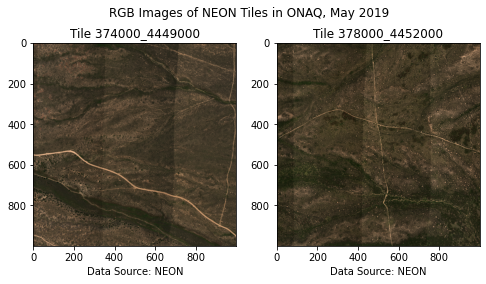

In [4]:
# Plot RGB images of tiles
fig = plt.figure(figsize=(8,4))
fig.suptitle('RGB Images of NEON Tiles in ONAQ, May 2019')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  

# Plot 1
ax0 = plt.subplot(gs[0])
ax0.set_xlabel('Data Source: NEON')
im0 = ax0.imshow(bytescale(ONAQ_data['374000_4449000']['reflectance'][:,:,[54, 34, 22]]))
plt.title('Tile 374000_4449000')

# Plot 2
ax1 = plt.subplot(gs[1])
ax1.set_xlabel('Data Source: NEON')
im1 = ax1.imshow(bytescale(ONAQ_data['378000_4452000']['reflectance'][:,:,[54, 34, 22]]))
plt.title('Tile 378000_4452000')

plt.show()

# Sensitivity Analysis for Tile 374000_4449000

In [5]:
# Create object for endmember extraction
ee = eea.NFINDR()

# Eun unsupervised endmember extraction for 4-11 endmembers
endmember_sensitivity_analysis=[]
for i in range(4,12):
     endmember_sensitivity_analysis.append(ee.extract(ONAQ_data['374000_4449000']['reflectance'],i,maxit=i+1,
               normalize=False,ATGP_init=True))

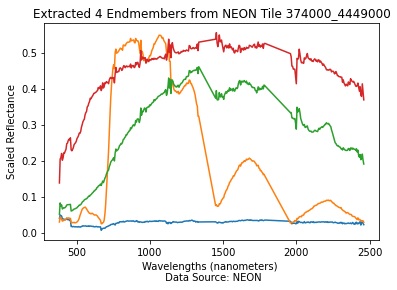

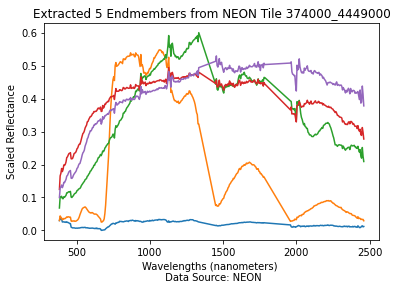

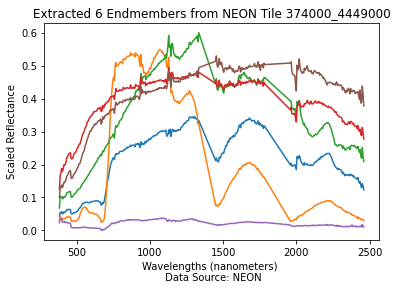

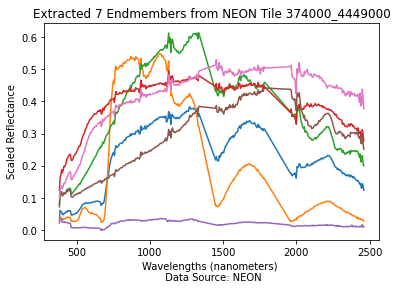

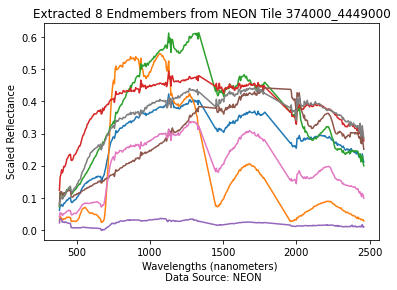

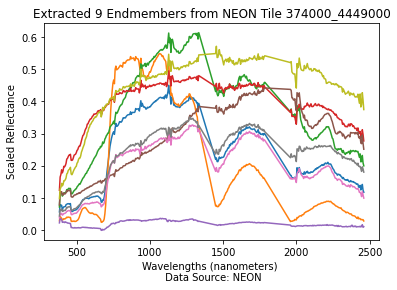

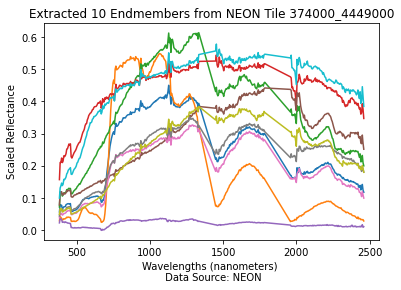

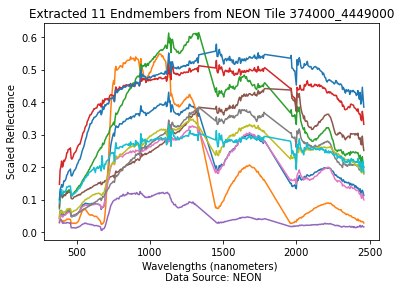

In [9]:
# Plot each iteration of endmembers
for em in endmember_sensitivity_analysis:
    fig,ax=plt.subplots()
    for refl in em:
        plt.title(f'Extracted {len(em)} Endmembers from NEON Tile 374000_4449000')
        ax.plot(ONAQ_data['374000_4449000']['metadata']['wavelength'],refl)
        ax.set_xlabel('Wavelengths (nanometers) \n Data Source: NEON')
        ax.set_ylabel('Scaled Reflectance')

# Sensitivity Analysis for Tile 378000_4452000

In [7]:
# Create object for ee with NFINDR
ee = eea.NFINDR()

# Run ESA for 4-12 endmembers
endmember_sensitivity_analysis_2=[]
for i in range(4,12):
     endmember_sensitivity_analysis_2.append(ee.extract(ONAQ_data['378000_4452000']['reflectance'],i,maxit=i+1,
               normalize=False,ATGP_init=True))

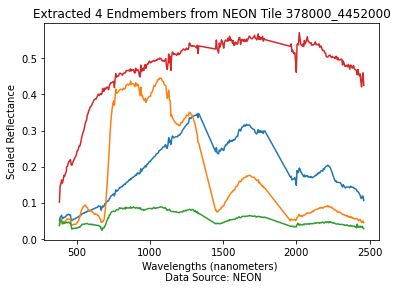

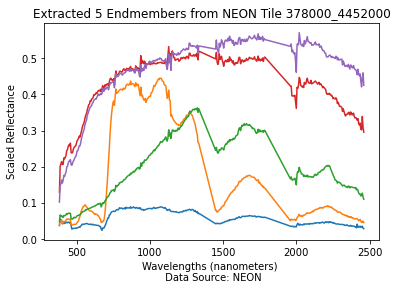

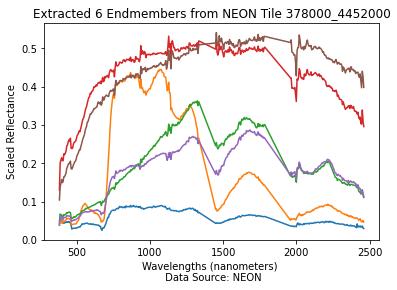

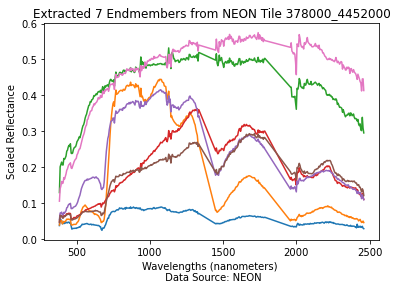

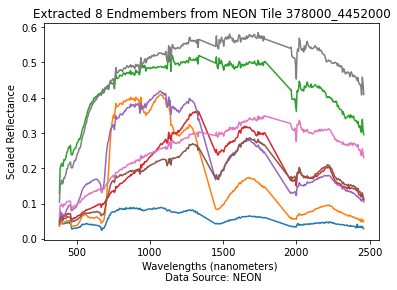

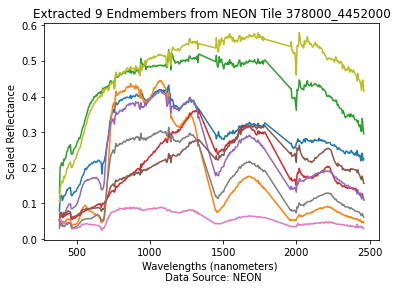

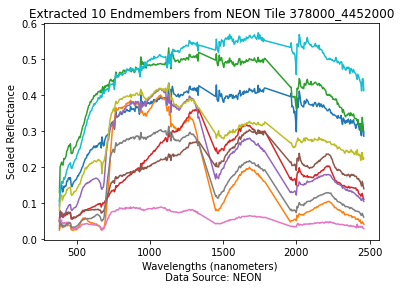

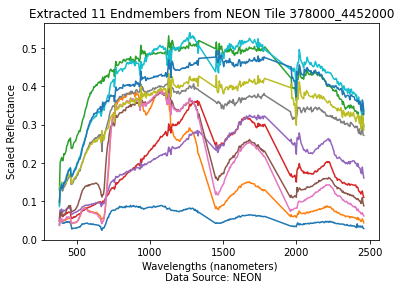

In [10]:
# Plot each iteration of extracted endmembers
for em in endmember_sensitivity_analysis_2:
    fig,ax=plt.subplots()
    for refl in em:
        plt.title(f'Extracted {len(em)} Endmembers from NEON Tile 378000_4452000')
        ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],refl)
        ax.set_xlabel('Wavelengths (nanometers) \n Data Source: NEON')
        ax.set_ylabel('Scaled Reflectance')

# Results

The results from tile 374000_4449000 and 378000_4452000 show an overall similarity in the spectral curves in each tile, but the reflectance values for tile 374000_4449000 make it difficult to discern the endmembers. This appears to be because the spectral curves for vegetation are reflecting a greater proportion of light than in tile 378000_4452000, and are therefore getting lost with the endmembers with soil-type reflectance curves. While this might not impact statistical comparison of the endmember spectral curves against the isolated spectral curves of the focal species, it is hard to visually disentangle the results. It also appears that there is more redundancy in these endmembers as the number of endmembers extracted increases. Consequently, analyses will move forward with tile 378000_4452000. 

Endmember extractions from 7-9 capture a promising range of distinct vegetation-type spectral signatures - indicating a variety of vegetative land covers in this tile. There is perhaps too much overlap in the 9 endmember extraction, and the 8 endmember extraction appears to add another soil-type spectral curve - though it is unclear without data validation what this is. Considering these results, the endmember extraction and abundance mapping will move forward with 7 endmember extraction.